In [1]:
!pip install keras-tuner

     |████████████████████████████████| 133 kB 5.5 MB/s 


In [2]:
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, AveragePooling1D , Flatten, Input, LSTM
from sklearn.model_selection import train_test_split
import pprint as pp
import keras_tuner as kt
from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


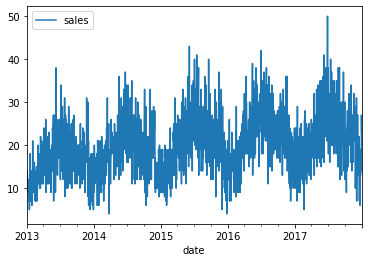

In [4]:
df = pd.read_excel("/content/drive/MyDrive/dataset.xlsx")
df.plot(x = 'date', y = 'sales')
plt.show()

In [5]:
raw_seq = df['sales']

In [6]:
train_seq = raw_seq[:1095]
val_seq = raw_seq[1095:1461].reset_index(drop=True)
test_seq = raw_seq[1461:].reset_index(drop=True)

In [7]:
print(train_seq.size, val_seq.size, test_seq.size)

1095 366 365


In [8]:
# univariate data preparation
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [9]:
n_steps = 30
n_features = 1
X_train, y_train = split_sequence(train_seq, n_steps)
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=10)
X_test, y_test = split_sequence(test_seq, n_steps)
X_val, y_val = split_sequence(val_seq, n_steps)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [10]:
def vanila_LSTM(hp):
    inputs = Input(shape=(30, 1))
    
    X = LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='tanh', recurrent_activation='sigmoid')(inputs)

    outputs = Dense(1)(X)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="vanilla_lstm_model")
    
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])

    return model

In [11]:
tuner = kt.tuners.Hyperband(
    vanila_LSTM,
    objective='val_mean_squared_error',
    max_epochs=30,
    hyperband_iterations=5,
    directory='vanilla_lstm_exp',
    project_name='demand forecasting')

In [12]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}


In [13]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [14]:
tuner.search(X_train_shuffled, y_train_shuffled, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

Trial 16 Complete [00h 00m 12s]
val_mean_squared_error: 50.90099334716797

Best val_mean_squared_error So Far: 47.89993667602539
Total elapsed time: 00h 03m 27s
INFO:tensorflow:Oracle triggered exit


In [15]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(30, 1))
best_model.summary()

Model: "vanilla_lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 320)               412160    
                                                                 
 dense (Dense)               (None, 1)                 321       
                                                                 
Total params: 412,481
Trainable params: 412,481
Non-trainable params: 0
_________________________________________________________________


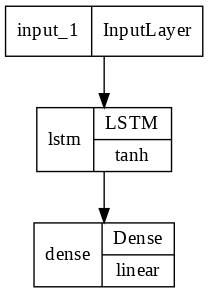

In [16]:
plot_model(best_model,  show_layer_activations=True, dpi=100)

In [17]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

In [18]:
hist =  best_model.fit(X_train, y_train, batch_size=120, epochs=2000, verbose=2, validation_data=(X_val, y_val), callbacks=[callback])
score = best_model.evaluate(X_test, y_test, return_dict=True)
y_pred = best_model.predict(X_test)

Epoch 1/2000
9/9 - 5s - loss: 40.7153 - mean_absolute_error: 5.1162 - root_mean_squared_error: 6.3809 - mean_absolute_percentage_error: 34.9205 - mean_squared_error: 40.7153 - val_loss: 47.9914 - val_mean_absolute_error: 5.4851 - val_root_mean_squared_error: 6.9276 - val_mean_absolute_percentage_error: 25.5277 - val_mean_squared_error: 47.9914 - 5s/epoch - 545ms/step
Epoch 2/2000
9/9 - 2s - loss: 39.8133 - mean_absolute_error: 5.0367 - root_mean_squared_error: 6.3098 - mean_absolute_percentage_error: 33.5959 - mean_squared_error: 39.8133 - val_loss: 52.1592 - val_mean_absolute_error: 5.6928 - val_root_mean_squared_error: 7.2221 - val_mean_absolute_percentage_error: 25.5919 - val_mean_squared_error: 52.1592 - 2s/epoch - 264ms/step
Epoch 3/2000
9/9 - 2s - loss: 38.9626 - mean_absolute_error: 4.9436 - root_mean_squared_error: 6.2420 - mean_absolute_percentage_error: 32.1164 - mean_squared_error: 38.9626 - val_loss: 54.2954 - val_mean_absolute_error: 5.8029 - val_root_mean_squared_error: 7

In [19]:
best_model.evaluate(X_train, y_train, return_dict=True)

34/34 [==============================] - 1s 33ms/step - loss: 21.3304 - mean_absolute_error: 3.6243 - root_mean_squared_error: 4.6185 - mean_absolute_percentage_error: 22.8939 - mean_squared_error: 21.3304


{'loss': 21.330442428588867,
 'mean_absolute_error': 3.6243367195129395,
 'mean_absolute_percentage_error': 22.893898010253906,
 'mean_squared_error': 21.330442428588867,
 'root_mean_squared_error': 4.6184892654418945}

In [20]:
best_model.evaluate(X_val, y_val, return_dict=True)

11/11 [==============================] - 0s 33ms/step - loss: 26.1601 - mean_absolute_error: 4.1117 - root_mean_squared_error: 5.1147 - mean_absolute_percentage_error: 20.2570 - mean_squared_error: 26.1601


{'loss': 26.160057067871094,
 'mean_absolute_error': 4.1117095947265625,
 'mean_absolute_percentage_error': 20.256986618041992,
 'mean_squared_error': 26.160057067871094,
 'root_mean_squared_error': 5.11469030380249}

In [21]:
score

{'loss': 28.508888244628906,
 'mean_absolute_error': 4.195590019226074,
 'mean_absolute_percentage_error': 20.768199920654297,
 'mean_squared_error': 28.508888244628906,
 'root_mean_squared_error': 5.339371681213379}

In [22]:
print(hist.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'mean_absolute_percentage_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'val_mean_absolute_percentage_error', 'val_mean_squared_error'])


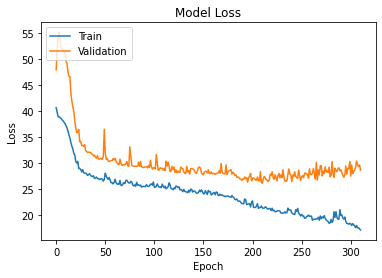

In [23]:
# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("vanilla_lstm_loss.png", dpi=300)
plt.show()

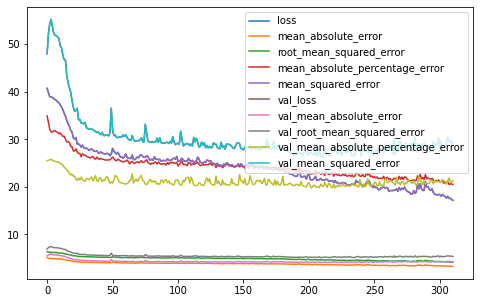

In [24]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.show()

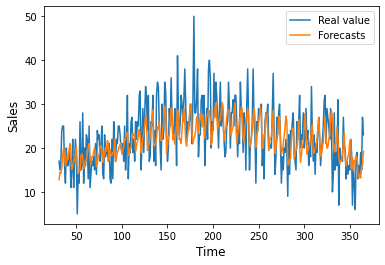

In [25]:
dates = np.array(range(31, 366))
plt.plot(dates, y_test, label='Real value')
plt.plot(dates, y_pred, label='Forecasts')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.savefig("vanilla_lstm_forecast.png", dpi=500)
plt.show()

In [26]:
from scipy import stats
stats.ttest_ind(y_pred, y_test)

Ttest_indResult(statistic=array([-1.8320248], dtype=float32), pvalue=array([0.0673928]))

In [27]:
best_model.save('vanilla_lstm.h5')